In [1]:
import torch
from torch import nn
from torch.functional import F
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths
import mat73
import scipy.io as sio
import sys
from timeit import default_timer as timer
import plotly
import plotly.graph_objs as go
from matplotlib import pyplot as plt, cm
from matplotlib import colors
import open3d as o3d
from torch import nn
import math
np.set_printoptions(threshold=sys.maxsize)

# from utilsReal.optim import Model, training_loop, bruteForce
# from utilsReal.generateBasis import generateBasisFunction
from utilsReal.helper import computeVisibility3D, pulse, lowPassFilter
from utilsReal.shape import carving

/var/folders/4p/0q_dfsrd3x13x_xh9k0_vc2r0000gn/T/ipykernel_66208/86770336.py:43: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(); plt.title('Spot ' + str(i+1))


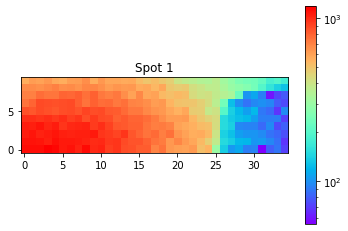

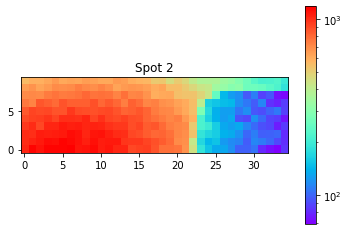

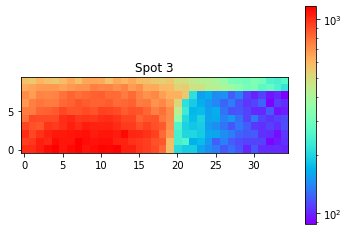

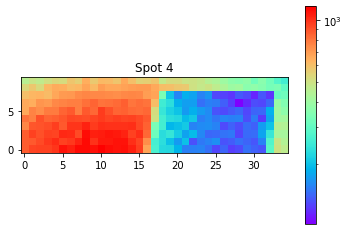

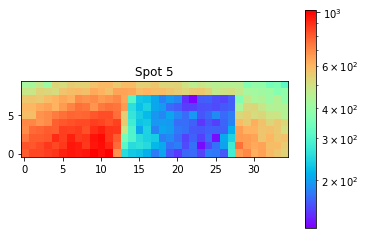

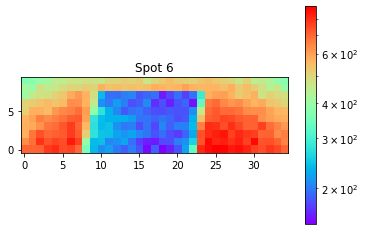

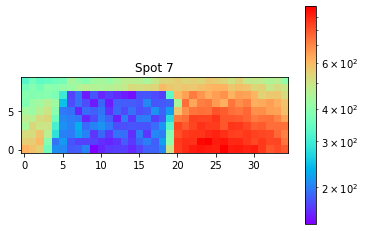

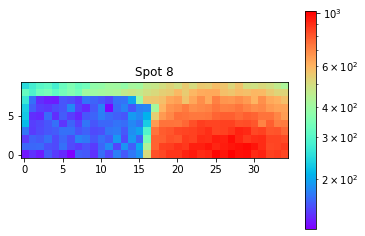

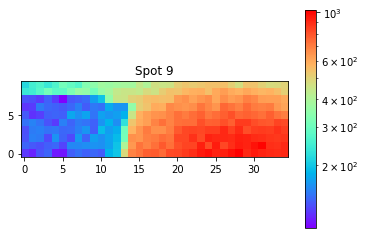

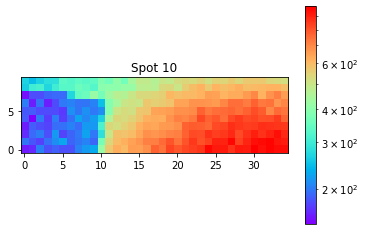

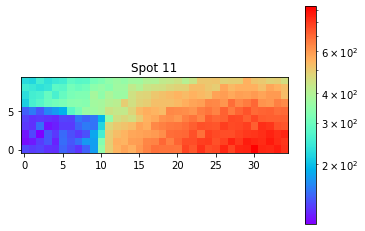

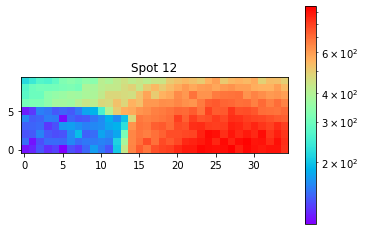

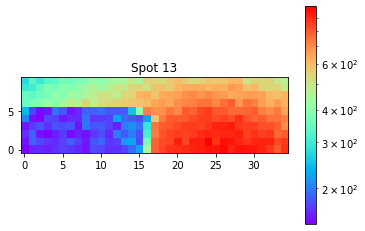

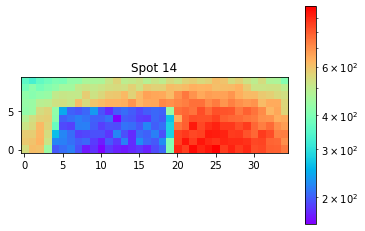

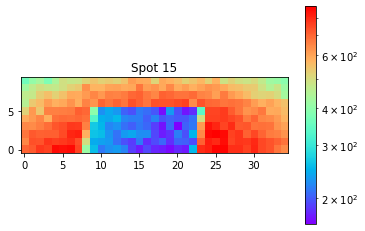

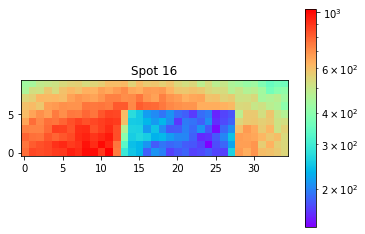

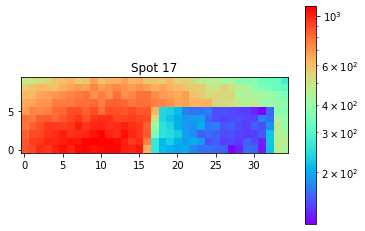

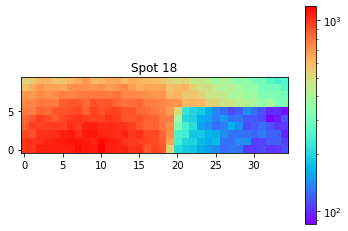

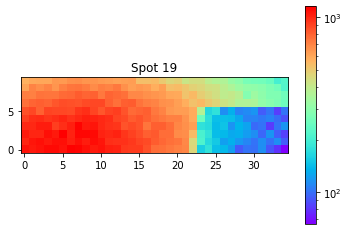

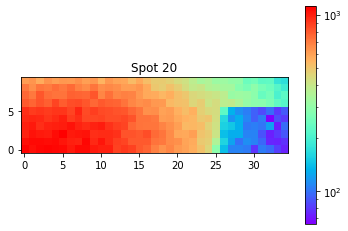

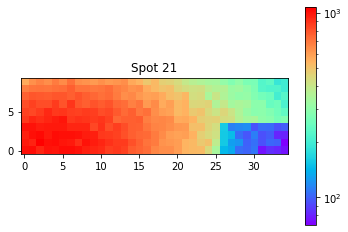

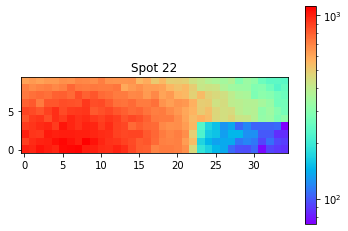

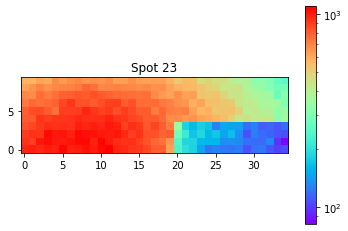

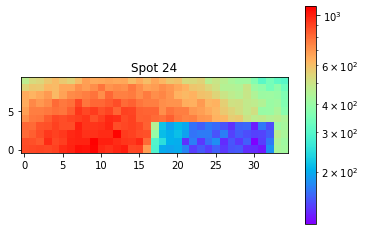

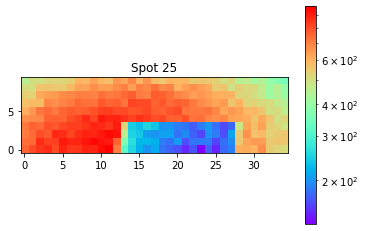

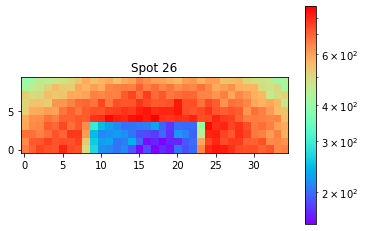

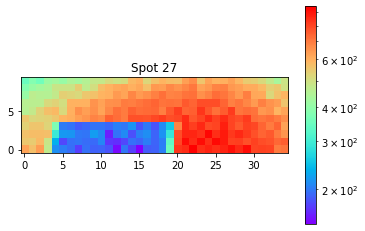

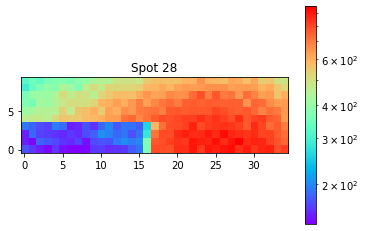

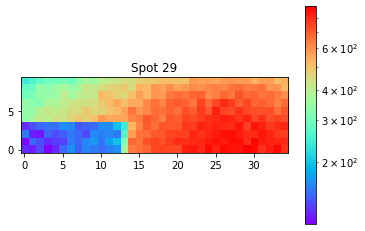

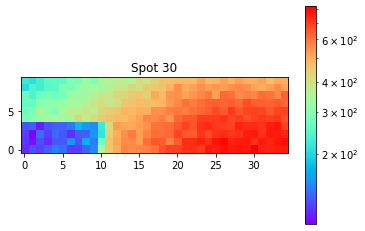

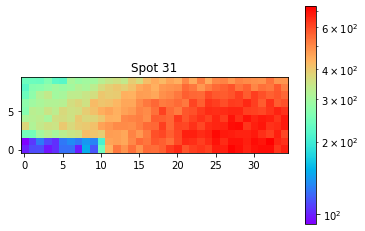

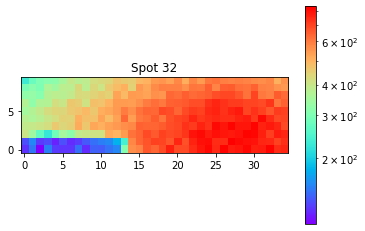

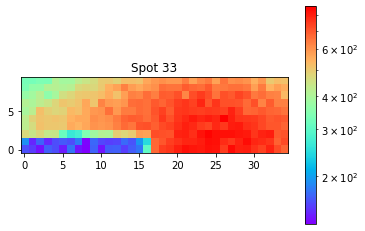

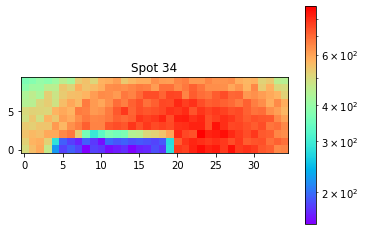

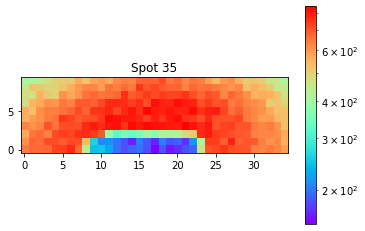

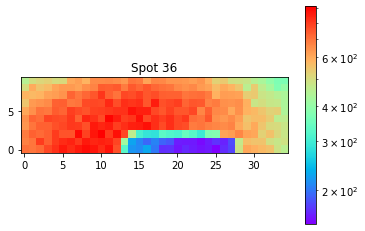

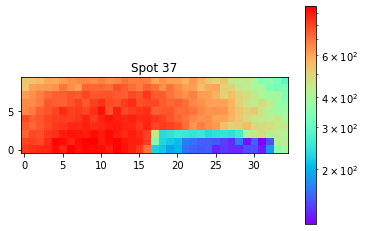

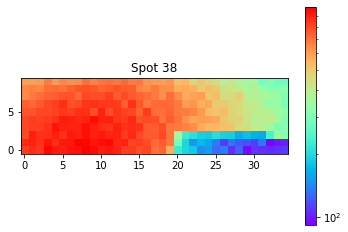

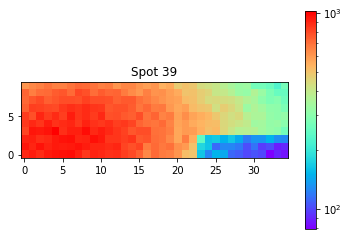

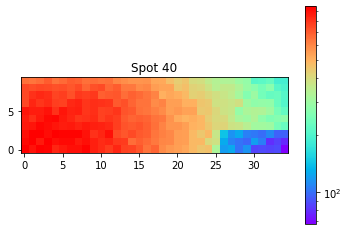

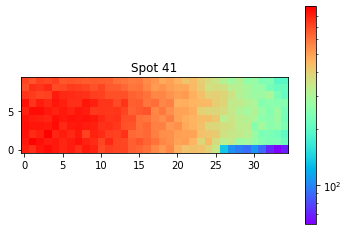

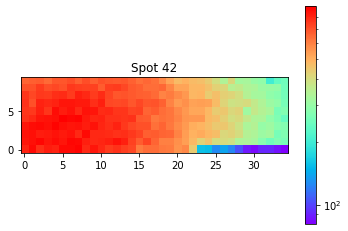

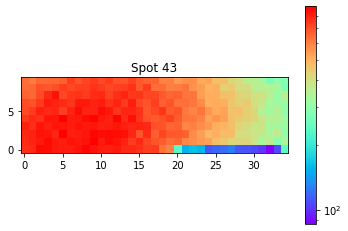

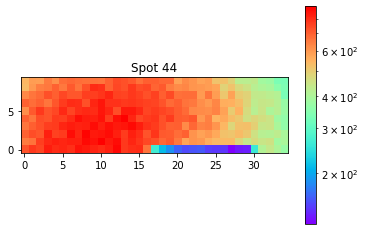

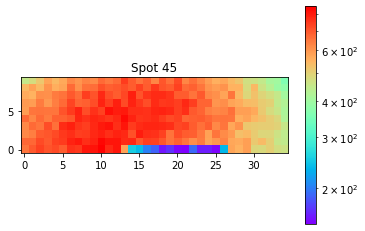

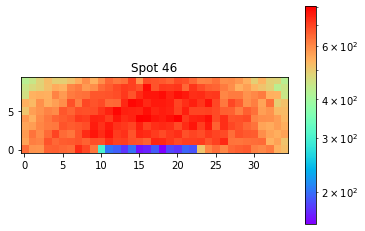

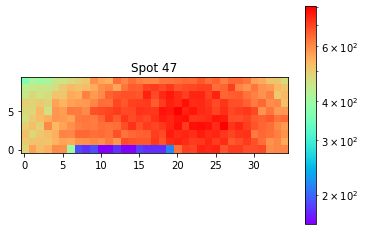

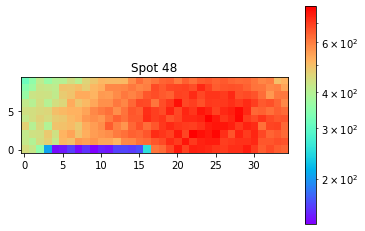

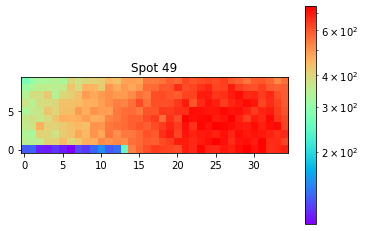

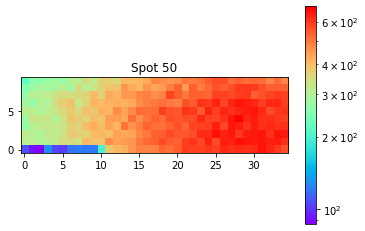

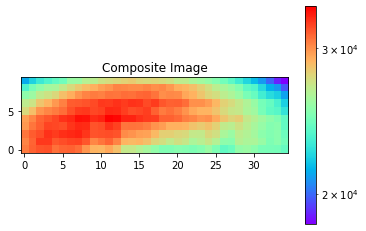

In [2]:
#####################################################################
####################### IMPORT TIME PROFILES ########################
#####################################################################

# data parameters
bin_width = 8E-12
t0 = 14.2428e-9; bin0 = round(t0 / bin_width)
numBins = 8192 - bin0
t = np.linspace(0, bin_width * (numBins-1), numBins)

# plot parameters
plotImgs = True

# detector parameters
num_u = 35; num_v = 10 # dimension of video
det_locs = sio.loadmat('../../data/multiplexed_twobounce_021322/results.mat')['x_p']
nc = np.array([0, 0, 1])

# laser parameters
las_locs = sio.loadmat('../../data/multiplexed_twobounce_021322/results.mat')['D']
numSpots = las_locs.shape[1]

# Import pulse
filename = '../../data/Bounce Flash/replica.mat'
pulseShape = np.squeeze(sio.loadmat(filename)['replica'])[bin0:]
pulseShape = np.roll(pulseShape, 50-np.argmax(pulseShape))
pulseShape = pulseShape / np.max(pulseShape)

# import histograms for relevant pixels
indiv_hists = np.zeros((numSpots, num_v, num_u, numBins)) # pixels 99-154
observation = np.zeros((num_v, num_u, numBins))
for i in range(numSpots):
    num = str(i+1)
    filename = '../../data/multiplexed_twobounce_021322/shadow_spot_' + num + '.mat'
    dataCube = mat73.loadmat(filename)['dataCube']
    dataCube_r = np.reshape(dataCube[:, bin0:], (num_v, num_u, numBins))
    
    indiv_hists[i, :, :, :] = dataCube_r
    observation += dataCube_r 
    
    # plot time-integrated images
    if plotImgs:
        plt.figure(); plt.title('Spot ' + str(i+1))
        t_int = np.sum(dataCube_r, 2)
        im = plt.imshow(t_int, cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
        plt.colorbar(im)
        
# # indiv_hists2 = lowPassFilter(t, indiv_hists, bin_width, 0.7E10, False)
# observations = np.sum(indiv_hists, axis=1)

# plot superimposed image
plt.figure(); plt.title('Composite Image')
im = plt.imshow(np.sum(observation, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
plt.colorbar(im)
plt.show()

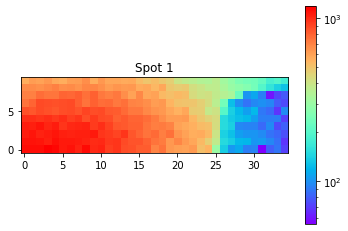

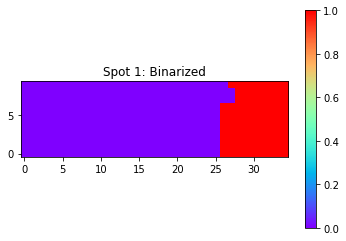

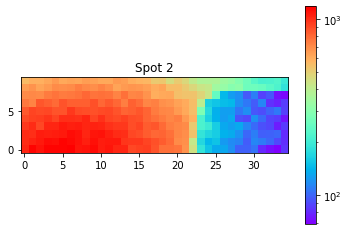

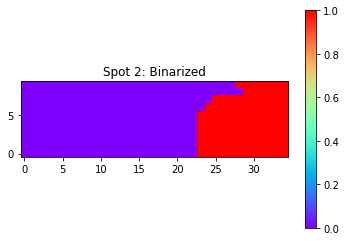

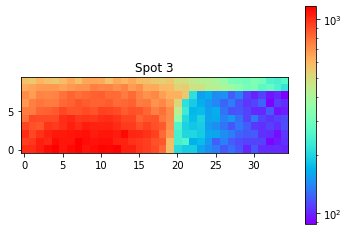

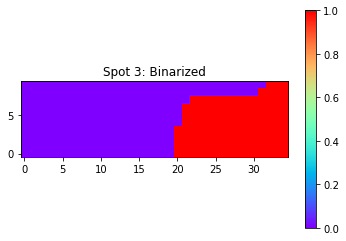

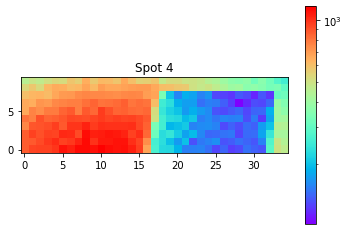

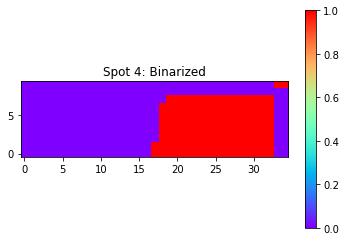

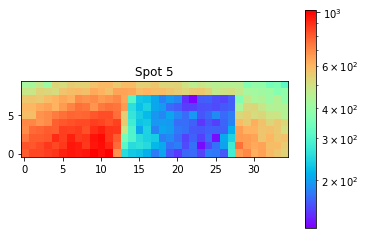

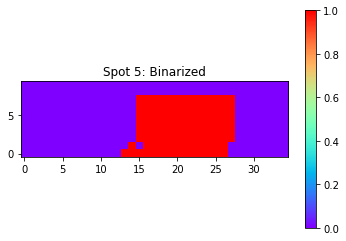

In [3]:
# construct visibility matrix
visibility = np.zeros((numSpots, num_v, num_u))
for i in range(5):
    plt.figure(); plt.title('Spot ' + str(i+1))
    t_int = np.sum(indiv_hists[i, :, :, :], 2)
    im = plt.imshow(t_int, cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
    plt.colorbar(im)
    plt.figure(); plt.title('Spot ' + str(i+1) + ': Binarized')
    im = plt.imshow(t_int < 0.25 * np.max(t_int), cmap=cm.rainbow, origin='lower')
    plt.colorbar(im)
    #     visibility[i, :, :] = 

In [4]:
# Save x, y, z data to .ply file if needed
comb_locs = np.vstack((det_locs, np.transpose(las_locs)))
if True:
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(comb_locs)
    o3d.io.write_point_cloud("../../data/multiplexed_twobounce_021322/comb.ply", pcd)

# Visualize point cloud (WARNING: This will open another window and you will be forced to kill kernal)
if True:
    cloud = o3d.io.read_point_cloud("../../data/multiplexed_twobounce_021322/comb.ply") # Read the point cloud
    o3d.visualization.draw_geometries([cloud])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


(10, 35, 6412)


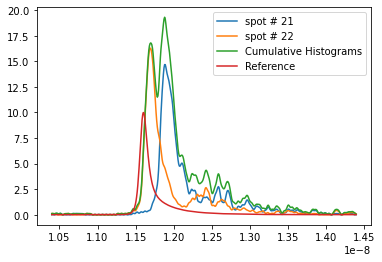

In [5]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'same') / w

i1 = 1300; i2 = 1800 
# i1 = 0; i2 = -1

# plot individual histograms
leg = []
plt.figure()
pixelHist = indiv_hists[i, 8, 5, i1:i2]
observation = np.zeros((num_v, num_u, numBins))
for i in range(20, 30-8):
    a = lowPassFilter(t, indiv_hists[i, 8, 5, :], bin_width, 2E10, False)
    a = moving_average(a, 10)
#     a = moving_average(indiv_hists[i, 8, 5, :], 1)
    observation += a
    plt.plot(t[i1:i2], a[i1:i2])
    leg.append('spot # ' + str(i+1))

# plot superimposed histogram
# observation = np.sum(indiv_hists[20:30, :, :, :] , axis=0)
print(observation.shape)
# plt.figure()
pixelHist = observation[8, 5, :]
plt.plot(t[i1:i2], pixelHist[i1:i2])
leg.append('Cumulative Histograms')
plt.plot(t[i1:i2], np.roll(10 * pulseShape, 1400)[i1:i2])
leg.append('Reference')
plt.legend(leg)


# Time Domain Optimization

In [18]:
def generateBasisFunction(las_locs, det_locs, t, pulseShape, bin_width, c):
    # inputs:
    #     src_locs - (x, y) pixels (numPixels x 3)
    #     det_locs - (x, y) pixels (numSpots x 3)
    #
    # output: 
    #     hists    - only pixels of interest (numPixels x numSpots x numBins)
    
    # constant parameters
    numPixels = det_locs.shape[0]
    numSpots = las_locs.shape[0]
    numBins = len(t)
    
    # define variables
    det_x = np.tile(np.reshape(det_locs[:, 0], (numPixels, 1)), (1, numSpots))
    det_y = np.tile(np.reshape(det_locs[:, 1], (numPixels, 1)), (1, numSpots))
    det_z = np.tile(np.reshape(det_locs[:, 2], (numPixels, 1)), (1, numSpots))
    
    las_x = np.tile(np.reshape(las_locs[:, 0], (1, numSpots)), (numPixels, 1))
    las_y = np.tile(np.reshape(las_locs[:, 0], (1, numSpots)), (numPixels, 1))
    las_z = np.tile(np.reshape(las_locs[:, 0], (1, numSpots)), (numPixels, 1))
    
    # compute tof
    r1 = (las_x**2 + las_y**2 + las_z**2)**0.5 
    r2 = ((det_x-las_x)**2 + (det_y-las_y)**2 + (det_z-las_z)**2)**0.5
    r3 = (det_x**2 + det_y**2 + det_z**2)**0.5
    pathLen = r1 + r2 + r3
    tof = (pathLen / c) #- t0
    
    # create array of pulses in fourier domain
    pulse_fft = np.reshape(np.fft.fft(np.squeeze(pulseShape)), (1, 1, numBins)) # 1 x 1 x numBins
    pulses_fft = np.tile(pulse_fft, (numPixels, numSpots, 1)) # numPixels x x numSpots x numBins
    f = np.reshape(np.fft.fftfreq(numBins, bin_width), (1, 1, numBins)) # 1 x 1 x numBins
    f_tiled = np.tile(f, (numPixels, numSpots, 1)) # numPixels x numSpots x numBins
    
    # shift pulses by tof
    tof_r = np.reshape(tof, (numPixels, numSpots, 1))
    freq_shift = pulses_fft * np.exp(-1j*2*math.pi*f_tiled*tof_r) 
    hists = np.abs(np.fft.ifft(freq_shift)) # assume pulse is completely positive. if not, use np.real()
    
#     # attenuation by albedo, r^2 falloff, cosine falloff (NOTE: make sure albedo values are reasonable)
#     r2_squared = r2**2
#     r3_squared = r3**2
    
#     rho1 = np.tile(np.reshape(albedo[las_yidx, las_xidx], (1, numSpots)), (numPixels, 1))
#     rho2 = np.tile(np.reshape(albedo[det_yidx, det_xidx], (numPixels, 1)), (1, numSpots))
    
#     n1 = np.tile(np.reshape(n_vector[las_yidx, las_xidx, :], (1, numSpots, 3)), (numPixels, 1, 1))
#     n2 = np.tile(np.reshape(n_vector[det_yidx, det_xidx, :], (numPixels, 1, 3)), (1, numSpots, 1))

#     wc1_unnorm = np.tile(np.reshape(pt_loc[las_yidx, las_xidx, :], (1, numSpots, 3)), (numPixels, 1, 1))
#     wc1 = wc1_unnorm / np.reshape(np.sum(wc1_unnorm**2, 2)**0.5, (numPixels, numSpots, 1))
#     w1c = -wc1
#     wc2_unnorm = np.tile(np.reshape(pt_loc[det_yidx, det_xidx, :], (numPixels, 1, 3)), (1, numSpots, 1))
#     wc2 = wc2_unnorm / np.reshape(np.sum(wc2_unnorm**2, 2)**0.5, (numPixels, numSpots, 1))
#     w12_unnorm = wc2_unnorm - wc1_unnorm
#     w12 = w12_unnorm / np.reshape(np.sum(w12_unnorm**2, 2)**0.5, (numPixels, numSpots, 1))
#     w21 = -w12
    
#     nc = np.tile(np.reshape(nc, (1, 1, 3)), (numPixels, numSpots, 1))
#     a = rho1 * rho2 * (dot(w12, n1) * dot(w21, n2) * dot(wc2, nc) / r2_squared)
# #     a = (rho1 * dot(w1c, n1) / r2_squared) * (rho2 * dot(w21, n2) / r3_squared) * dot(wc2, nc)

#     hists *= scale * np.reshape(a, (numPixels, numSpots, 1)) 
    
    return tof, hists

class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, numPixels, numSpots):
        super().__init__()
        # initialize weights with random numbers
        vis = torch.rand(numPixels, numSpots)
        vis = torch.where(vis > 0.5, 1.0, 0.0)
        
        # make weights torch parameters
        self.vis = nn.Parameter(vis, requires_grad = True)      
        
    def forward(self, hists):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
#         vis = torch.sigmoid(self.vis)
        vis = self.vis
        obs = torch.sum(hists * vis.unsqueeze(-1), axis=1)
        return obs

def training_loop(model, histograms, observations, optimizer, thresh, lam, n=1000):
    "Training loop for torch model."
    losses = []
    prev_loss = 0
    for i in range(n):
        preds = model(histograms)
        loss1 = F.mse_loss(preds, observations) 
        loss2 = torch.sum(torch.square(torch.diff(model.vis, n=1, axis=0))) 
        loss = loss1 + lam * loss2
        cur_loss = loss.detach().numpy()
        losses.append(cur_loss)  
        if np.abs(prev_loss-cur_loss) < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
    return losses

In [19]:
detLocs = np.reshape(det_locs, (num_v, num_u, 3))
lasLocs = np.reshape(las_locs, (5, 10, 3))
print(detLocs.shape)
print(lasLocs.shape)

(10, 35, 3)
(5, 10, 3)


(10, 3)
(10, 3)
(10, 10, 6412)


Text(0, 0.5, 'Pixel')

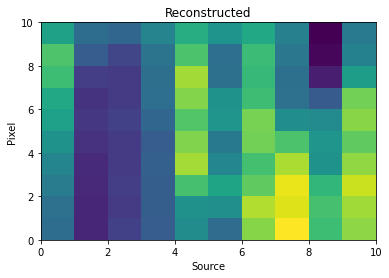

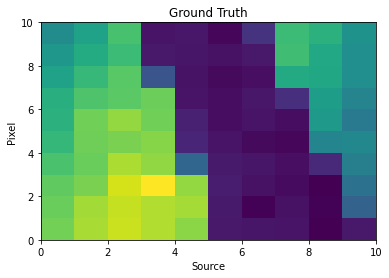

In [37]:
#####################################################################
####### SOLVE INVERSE PROBLEM (RECONSTRUCT VISIBILITY MATRIX) #######
#####################################################################
observation = np.sum(indiv_hists[20:30, :, :, :], axis=0)
obs = observation[2, 10:20, :]
detLocs_line = detLocs[2, 5:15, :]
lasLocs_line = lasLocs[2, :, :]
numPixels = detLocs_line.shape[0]
numSpots = lasLocs_line.shape[0]
print(detLocs_line.shape)
print(lasLocs_line.shape)

vis_gt = np.sum(indiv_hists[20:30, 2, 10:20, :], axis=2)
vis_gt = np.transpose(vis_gt)

c = 299792458# 3E8 / 1.0003
# optimization parameters
numIters = 3000
thresh = 1E-100
lr_rate = 0.1
lam = 1E-4 # 5E2 for noiseless case

# object parameters
pixelSize = 0.01 # meters

# plotting parameters
plotData = False
plotError = False
plotSetup = True  
    
# generate basis functions
tof, hists = generateBasisFunction(lasLocs_line, detLocs_line, t, pulseShape, bin_width, c)
print(hists.shape)

# gradient descent
m = Model(numPixels, numSpots)
opt = torch.optim.Adam(m.parameters(), lr=lr_rate)

obs_filt = torch.tensor(obs)
hists_norm = torch.tensor(hists)

losses = training_loop(m, hists_norm, obs_filt, opt, thresh, lam, n=500)
vis = m.vis.detach()
# vis = torch.sigmoid(vis)
v_reconst = vis
# v_reconst = torch.where(vis > 0.5, 1, 0).numpy()
# v_reconst = bruteForce(np.ones((numPixels, numSpots)), hists.detach().numpy(), observations.detach().numpy())

# plot optimization loss
if plotError:
    plt.figure(figsize=(14, 7))
    plt.plot(losses)

# plot visibility matrix
plt.figure()
plt.title('Reconstructed')
plt.pcolormesh(v_reconst)
plt.xlabel('Source'); plt.ylabel('Pixel')
# plt.title('t0 = ' + str(t0))

plt.figure()
plt.title('Ground Truth')
plt.pcolormesh(vis_gt)
plt.xlabel('Source'); plt.ylabel('Pixel')

# compare ground truth visibility matrix
# error = np.sum(np.abs(v_reconst-vis_gt))
# pct_error = 100 * error / (numSpots_y * numPixels_z * numPixels_y)
# print(str(error) + ' / ' + str(numPixels_z * numPixels_y * numSpots_y) + ' entries in visibility matrix misclassified')
# print(str(pct_error) + '% of entries in visibility matrix misclassified')

# onesToZero = np.sum(np.abs(v_reconst-vis_gt) * vis_gt)
# print(str(onesToZero) + ' ones flipped to zeros')
# print(str(100 * onesToZero / error) + '% of misclassified entries were ones flipped to zeros')
# end = timer()
# print(end - start)

In [35]:

print(vis_gt.shape)

(10, 10)


In [31]:
indiv_hists.shape

(50, 10, 35, 6412)

In [30]:
detLocs_line.shape

(10, 3)

# Prony's Method

In [ ]:
import math
def fourierSeries(t, a, M, numBins, f0, w0, f_samples, plotSpectrum):
    # compute FFT of signal
    a_fft = np.fft.fft(a)
    a_fft_shift = np.fft.fftshift(a_fft)
    f = np.fft.fftfreq(numBins, bin_width)
    f_shift = np.fft.fftshift(f)

    # determine which fourier coefficients to use
    diff = np.abs(np.reshape(f_samples, (2*M+1, 1)) - np.reshape(f_shift, (1, numBins)))
    idx = np.argmin(diff, axis=1)
    # p_hat = a_fft_shift[idx] * 0.45E-2

    # plot FFT of signal and fourier coefficients used
    if plotSpectrum:
        plt.figure()
        plt.title('FFT Magnitude')
        t0 = 0; t1 = numBins
        y = np.abs(a_fft_shift[t0:t1])
        plt.plot(f_shift[t0:t1], y)
        plt.plot(f_shift[idx], y[idx], 'ro')

    # compute fourier series approximation
    m = np.tile(np.reshape(np.linspace(-M, M, 2*M+1), (1, 2*M+1)), (numBins, 1))
    mw_0t = m * np.reshape(w0*t, (numBins, 1))
    comp_exps = np.exp(1j*mw_0t)
    p_hat = f0 * np.sum(np.reshape(a, (numBins, 1))*np.exp(-1j*mw_0t), axis=0) * bin_width
     
    return comp_exps, p_hat

In [ ]:
from numpy.linalg import svd
def nullspace(A, atol=1e-13, rtol=0):
    """Compute an approximate basis for the nullspace of A.

    The algorithm used by this function is based on the singular value
    decomposition of `A`.

    Parameters
    ----------
    A : ndarray
        A should be at most 2-D.  A 1-D array with length k will be treated
        as a 2-D with shape (1, k)
    atol : float
        The absolute tolerance for a zero singular value.  Singular values
        smaller than `atol` are considered to be zero.
    rtol : float
        The relative tolerance.  Singular values less than rtol*smax are
        considered to be zero, where smax is the largest singular value.

    If both `atol` and `rtol` are positive, the combined tolerance is the
    maximum of the two; that is::
        tol = max(atol, rtol * smax)
    Singular values smaller than `tol` are considered to be zero.

    Return value
    ------------
    ns : ndarray
        If `A` is an array with shape (m, k), then `ns` will be an array
        with shape (k, n), where n is the estimated dimension of the
        nullspace of `A`.  The columns of `ns` are a basis for the
        nullspace; each element in numpy.dot(A, ns) will be approximately
        zero.
    """

    A = np.atleast_2d(A)
    u, s, vh = svd(A)
    tol = max(atol, rtol * s[0])
    nnz = (s >= tol).sum()
    ns = vh[nnz:].conj().T
    return ns

In [ ]:
#####################################################################
########################## DETERMINE Y_HAT ##########################
#####################################################################
# pixelHist = observation[, 10, :]

M = 400
plotSpectrum = True
T = (numBins-1)*bin_width
f0 = 1/T; w0 = 2*math.pi*f0
f_samples = f0 * np.reshape(np.linspace(-M, M, 2*M+1), (2*M+1, 1))
exps_p, p_hat = fourierSeries(t, pulseShape, M, numBins, f0, w0, f_samples, True)

m_t = pixelHist # low-pass filtered measurements (N x 1)
V = exps_p # Vandermonde matrix (N x (2M + 1))
D = np.diag(p_hat) # diagonal matrix containing pulse Fourier coefficients (2M+1) x (2M+1)
D_inv = np.diag(1 / p_hat)

y_hat = np.matmul(np.matmul(D_inv, np.linalg.pinv(V)), m_t)

In [ ]:
#####################################################################
########################## PRONY'S METHOD ###########################
#####################################################################
K = 2
y_hat_cut = np.squeeze(y_hat[M+1:])

# generate Toeplitz matrix to solve for q
T = np.zeros((M-K, K+1)) + 0j
# for i in range(K+1):
#     idx1 = (K+1-i)-1; idx2 = 2*K-i
#     T[:, i] = y_hat_cut[idx1:idx2]
for i in range(M-K):
    idx1 = i; idx2 = K+1+i
    T[i, :] = np.flipud(y_hat_cut[idx1:idx2])

# solve polynomial to obtain q
q = nullspace(T, 1E-12, 9E-2)
print(q.shape)

# 
for i in range(q.shape[1]):
    print('Prediction ' + str(i+1) +':')
    e_t_k = np.roots(np.squeeze(q[:, i]))
    t_k = -1E9*np.angle(e_t_k) / w0
    print(t_k)
#     print(t_k / (1E9*bin_width))

i1 = 0; i2 = -1
plt.plot(t[i1:i2]*1E9, pixelHist[i1:i2])

In [ ]:
i1 = 0; i2 = -1
plt.plot(t[i1:i2]*1E9, pixelHist[i1:i2])

# Overleaf Frequency Domain Method

In [ ]:
def dot(vec1, vec2):
    # input: m x n x 3 matrices
    return np.sum(vec1 * vec2, axis=-1)

In [ ]:
#####################################################################
####################### COMPUTE GAMMA AND PHI #######################
#####################################################################
c = 299792458

# compute pixel-wise positions in real-world coordinates
det_x = pt_loc[y_locs, x_locs, 0]
det_y = pt_loc[y_locs, x_locs, 1]
det_z = pt_loc[y_locs, x_locs, 2]

las_x = pt_loc[las_locs[0, 1], las_locs[0, 0], 0]
las_y = pt_loc[las_locs[0, 1], las_locs[0, 0], 1]
las_z = pt_loc[las_locs[0, 1], las_locs[0, 0], 2]

# compute pixel-wise tof
r1 = (las_x**2 + las_y**2 + las_z**2)**0.5 
r2 = ((det_x-las_x)**2 + (det_y-las_y)**2 + (det_z-las_z)**2)**0.5
r3 = (det_x**2 + det_y**2 + det_z**2)**0.5
pathLen = r1 + r2 + r3
tof = (pathLen / c) - 6.4E-10
phi = w0 * tof
# tof += t0
r2_squared = r2**2

# compute pixel-wise albedos
rho1 = albedo[las_locs[0, 1], las_locs[0, 0]]
rho2 = albedo[y_locs, x_locs]

# compute pixel-wise surface normals
n1 = np.reshape(n_vector[las_locs[0, 1], las_locs[0, 0], :], (1, 1, 3))
n2 = n_vector[y_locs, x_locs, :]

# compute propogation vectors
wc1_unnorm = np.reshape(pt_loc[las_locs[0, 1], las_locs[0, 0], :], (1, 1, 3))
wc1 = wc1_unnorm / (np.sum(wc1_unnorm**2)**0.5)
w1c = -wc1
wc2_unnorm = pt_loc[y_locs, x_locs, :]
wc2 = wc2_unnorm / np.reshape(np.sum(wc2_unnorm**2, 2)**0.5, (numYsamps, numXsamps, 1))
w12_unnorm = wc2_unnorm - wc1_unnorm
w12 = w12_unnorm / np.reshape(np.sum(w12_unnorm**2, 2)**0.5, (numYsamps, numXsamps, 1))
w21 = -w12
    
Gamma = 3000 * rho1 * rho2 * (dot(w12, n1) * dot(w21, n2) * dot(wc2, nc) / r2_squared)

In [ ]:
class Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self, numPixels):
        super().__init__()
        # initialize weights with random numbers
        vis = torch.rand(numPixels)
        vis = torch.where(vis > 0.5, 1, -1) + torch.tensor(0j, dtype=torch.cdouble)
        
        # make weights torch parameters
        self.vis = nn.Parameter(vis, requires_grad = True)      
        
    def forward(self, A):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        vis = torch.sigmoid(torch.abs(self.vis)) + 0j
        obs = torch.matmul(A, vis)
        return obs
    
def complexLoss(target, output):
    loss = torch.sum(torch.abs(output - target)) / target.shape[0]
    return loss

def training_loop(model, A, y_hat, optimizer, thresh, lam, n=1000):
    "Training loop for torch model."
    losses = []
    prev_loss = 0
    for i in range(n):
        preds = model(A)
        loss1 = complexLoss(preds, y_hat) 
        vis_resh = torch.reshape(torch.sigmoid(torch.abs(model.vis)), (numYsamps, numXsamps))
#         vis_resh = torch.sigmoid(torch.abs(torch.tensor(np.reshape(model.vis.detach().numpy(), (5, 10), order = 'C'))))
        loss2 = torch.sum(torch.square(torch.diff(vis_resh, n=1, axis=0))) + torch.sum(torch.square(torch.diff(vis_resh, n=1, axis=1)))
        loss = loss1 + lam * loss2
#         print(loss1)
        cur_loss = loss.detach().numpy()
        losses.append(cur_loss)  
        if np.abs(prev_loss-cur_loss) < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
    return losses

In [ ]:
#####################################################################
####################### SOLVE FOR VISIBILITY ########################
#####################################################################
# construct A matrix 
phi_flat = np.reshape(np.ndarray.flatten(phi, order='C'), (1, numXsamps*numYsamps))
comp_exps = np.exp(-1j * phi_flat * np.tile(np.reshape(np.linspace(-M, M, 2*M+1), (2*M+1, 1)), (1, numXsamps*numYsamps)))
Gamma_flat = np.reshape(np.ndarray.flatten(Gamma, order='C'), (1, numXsamps*numYsamps))
A = Gamma_flat * comp_exps
y_hat = np.squeeze(y_hat)

# optimization
thresh = 1E-100
numIters = 3000
lr_rate = 1E-2
lam = 0.5E2
plotError = True
m = Model(numXsamps*numYsamps)
opt = torch.optim.Adam(m.parameters(), lr=lr_rate)
losses = training_loop(m, torch.tensor(A), torch.tensor(y_hat), opt, thresh, lam, numIters)
vis = torch.real(m.vis.detach())
vis = torch.sigmoid(vis)
v_reconst = torch.where(vis > 0.5, 1, 0).numpy()
v_reconst = vis.numpy()
print(v_reconst)

# plot optimization loss
if plotError:
    plt.figure(figsize=(14, 7))
    plt.plot(losses)

plt.figure(figsize=(10, 5)); 
plt.subplot(1, 2, 1)
plt.title('Predicted Visibility Matrix')
plt.pcolormesh(np.reshape(v_reconst, (numYsamps, numXsamps), order='C')); plt.colorbar()

plt.subplot(1, 2, 2)
plt.title('GT shadow image')
plt.pcolormesh(np.sum(dn_samp_hists, 2)); plt.colorbar()


# im = plt.imshow(np.sum(dn_samp_hists, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
# plt.colorbar(im)

# im = plt.imshow(np.sum(dn_samp_hists, 2), cmap=cm.rainbow, norm=colors.LogNorm(), origin='lower')
# plt.colorbar(im)
# compare ground truth visibility matrix
# error = np.sum(np.abs(v_reconst-vis_gt))
# pct_error = 100 * error / (numSpots * numPixels)
# print(str(error) + ' / ' + str(numPixels*numSpots) + ' entries in visibility matrix misclassified')
# print(str(pct_error) + '% of entries in visibility matrix misclassified')

# onesToZero = np.sum(np.abs(v_reconst-vis_gt) * vis_gt)
# print(str(onesToZero) + ' ones flipped to zeros')
# print(str(100 * onesToZero / error) + '% of misclassified entries were ones flipped to zeros')
# end = timer()
# print(end - start)

# OMP

In [ ]:
#####################################################################
###################### DETERMINE 2-BOUNCE TOFs ######################
#####################################################################
from sklearn.linear_model import OrthogonalMatchingPursuit

# construct dictionary matrix P
t_min = 15.4; t_max = 15.9 # in nanoseconds
inc_size = 1E-12
L = 1 + int((t_max - t_min) / (inc_size * 1E9))
shifts = 1E-9 * np.linspace(t_min, t_max, L)
P = np.zeros((numBins, L))
for i in range(L):
    a = np.roll(pulseShape, round(shifts[i] / bin_width))
    P[:, i] = np.array(a) / np.max(a)
    
# compute K-sparse representation
omp = OrthogonalMatchingPursuit(n_nonzero_coefs=4, normalize=False)
# observation = observations[-1, :]
# observation = reconst_filt
omp.fit(P, observation)

# plot sparse recovery
coef = omp.coef_
(idx_r,) = coef.nonzero()
tof_preds = shifts[idx_r]
plt.figure()
plt.xlim(0, L)
plt.title("Recovered signal from noise-free measurements")
plt.stem(idx_r, coef[idx_r], use_line_collection=True)

# plot reconstructed sparse signal
plt.figure()
reconst = np.zeros(numBins)
t0 = 0; t1 = -1; t_val = t[t0:t1]; 
for i in idx_r:
    if coef[i] > -60000:
        reconst += coef[i] * P[:, i]
        plt.plot(1E9*t_val, coef[i] * P[t0:t1, i])
plt.figure()
plt.plot(1E9*t_val, observation[t0:t1])
plt.plot(1E9*t_val, reconst[t0:t1])
plt.xlabel('t (ns)')
plt.ylabel('Amplitude (a.u)')
plt.legend(['Observed', 'Reconstructed'])

In [ ]:
numSpots = 8; pixNumb = 0; 
gt_weight = np.max(dn_samp_hists, axis=2)
idx_r_sort = np.flip(np.argsort(coef))[0:numSpots]
plt.figure()
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (a.u)')
plt.title('Reconstructed Histograms')
leg = []
for i in range(numSpots):
    plt.plot(1E9*t[i1:i2], coef[idx_r_sort[i]]*P[i1:i2, idx_r_sort[i]])
    leg.append(str(i+1))
plt.legend(leg)
plt.figure()
plt.xlabel('Time (ns)')
plt.ylabel('Intensity (a.u)')
plt.title('Original Histograms')
leg = []; 
for x in range(2):
    for y in range(numYsamps):
        a = dn_samp_hists[y, x, :]
#         filt = lowPassFilter(t, a, bin_width, 0.5E10, False)
        plt.plot(t[i1:i2]*1E9, a[i1:i2])
        leg.append('x = ' + str(x+1) + ', y = ' + str(y+1))
plt.legend(leg)
print('-'*50)
print('GT tof')
print(np.ndarray.flatten(tofs[:, 0:2]))
print('-'*50)
print('Estimated tof')
print(shifts[idx_r_sort])
print('-'*50)
print('GT Weights')
print(np.ndarray.flatten(gt_weight[:, 0:2]))
print('-'*50)
print('Estimated Weights')
print(coef[idx_r_sort])
plt.figure()
plt.xlabel('Predicted ToF (ns)')
plt.plot(1E9*shifts[idx_r_sort], np.ones(len(idx_r_sort)), 'ro')
plt.plot(1E9*np.ndarray.flatten(tofs[:, 0:2]), np.ones(2), 'bo')
plt.xlim([15.45, 15.8])
plt.legend(['Predicted ToF', 'GT ToF'])

# Predict Time offset (not a solution)

In [ ]:
class t0Model(nn.Module):
    """Custom Pytorch model for gradient optimization.
    """
    def __init__(self):
        super().__init__()
        # initialize weights with random numbers
        t0 = torch.tensor(1E-8)
        
        # make weights torch parameters
        self.t0 = nn.Parameter(t0, requires_grad=True)      
        
    def forward(self, indiv_hists, pulses_fft, f_tiled):
        """Implement function to be optimised. In this case, an exponential decay
        function (a + exp(-k * X) + b),
        """
        numPixels, numSpots, numBins = indiv_hists.shape
        tof = torch.tile(torch.reshape(self.t0, (1, 1, 1)), (numPixels, numSpots, numBins))
        freq_shift = pulses_fft * torch.exp(-1j * 2*math.pi*f_tiled*tof) 
                         
        new_hists = torch.abs(torch.fft.ifft(freq_shift))
        corr = torch.sum(new_hists * indiv_hists)
        return corr

def t0_training_loop(model, indiv_hists, pulses_fft, f_tiled, optimizer, thresh, n=1000):
    "Training loop for torch model."
    losses = []
    prev_loss = 0
    for i in range(n):
        corr = model(indiv_hists, pulses_fft, f_tiled)
        loss = -corr
        cur_loss = loss.detach().numpy()
        losses.append(cur_loss)  
        if np.abs(prev_loss-cur_loss) < thresh:
            break
        loss.backward()
#         print(model.debug_v.grad.data)
        optimizer.step()
        optimizer.zero_grad()
    return losses

pulses_fft = np.fft.fft(hists)
f = np.reshape(np.fft.fftfreq(numBins, bin_width), (1, 1, numBins))
f_tiled = np.tile(f, (numPixels, numSpots, 1)) 
                         
mt = t0Model()
opt = torch.optim.Adam(mt.parameters(), lr=lr_rate)
losses = t0_training_loop(mt, torch.tensor(indiv_hists), torch.tensor(pulses_fft), torch.tensor(f_tiled), opt, 1E-100, n=500)
t0_guess = mt.t0.detach()